# Tutorial 3: Initializing a large-scale chain

### Laila Zaidi: Rutford Ice Stream

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from gstatsMCMC import Topography
from gstatsMCMC import MCMC
import gstatsim as gs
from sklearn.preprocessing import QuantileTransformer
import skgstat as skg

In [6]:
# load compiled bed elevation measurements
df = pd.read_csv('RutfordDataGridded.csv')

In [7]:
# create a grid of x and y coordinates
x_uniq = np.unique(df.x)
y_uniq = np.unique(df.y)

xmin = np.min(x_uniq)
xmax = np.max(x_uniq)
ymin = np.min(y_uniq)
ymax = np.max(y_uniq)

cols = len(x_uniq)
rows = len(y_uniq)

resolution = 500

xx, yy = np.meshgrid(x_uniq, y_uniq)

In [8]:
# load other data
dhdt = df['dhdt'].values.reshape(xx.shape)
smb = df['smb'].values.reshape(xx.shape)
velx = df['velx'].values.reshape(xx.shape)
vely = df['vely'].values.reshape(xx.shape)
bedmap_mask = df['bedmap_mask'].values.reshape(xx.shape)
bedmachine_thickness = df['bedmachine_thickness'].values.reshape(xx.shape)
bedmap_surf = df['bedmap_surf'].values.reshape(xx.shape)
highvel_mask = df['highvel_mask'].values.reshape(xx.shape)
bedmap_bed = df['bedmap_bed'].values.reshape(xx.shape)

In [9]:
bedmachine_bed = bedmap_surf - bedmachine_thickness

In [10]:
# create conditioning data
# bed elevation measurement in grounded ice region, and bedmachine bed topography elsewhere
cond_bed = np.where(bedmap_mask == 1, df['bed'].values.reshape(xx.shape), bedmap_bed)
df['cond_bed'] = cond_bed.flatten()

# create a mask of conditioning data
data_mask = ~np.isnan(cond_bed)

(-1461500.0, -1233500.0, 14500.0, 177000.0)

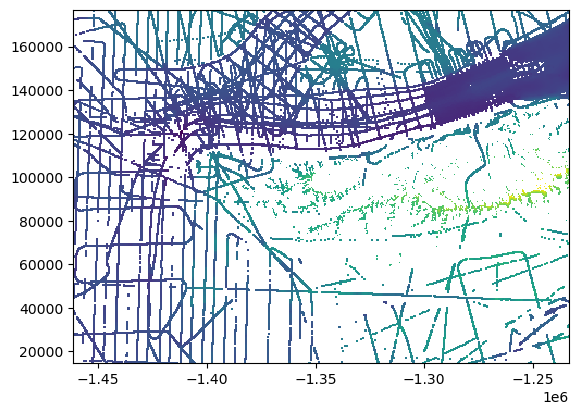

In [11]:
plt.pcolormesh(xx,yy,cond_bed)
plt.axis('scaled')

In [12]:
# normalize the conditioning bed data, saved to df['Nbed']
data = df['cond_bed'].values.reshape(-1,1)
nst_trans = QuantileTransformer(n_quantiles=500, output_distribution="normal",random_state=0).fit(data)
transformed_data = nst_trans.transform(data)
df['Nbed'] = transformed_data

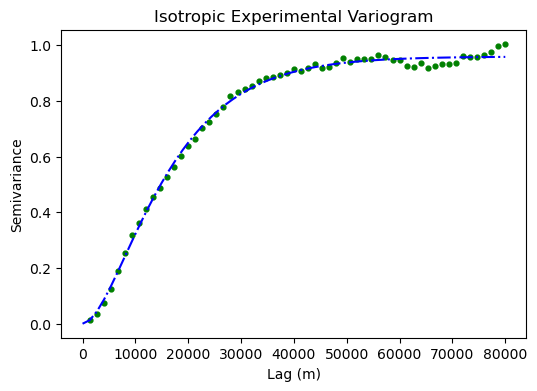

In [13]:
# randomly drop out 50% of coordinates. Decrease this value if you have a lot of data and it takes a long time to run
df_sampled = df.sample(frac=0.4, random_state=42)
df_sampled = df_sampled[df_sampled["cond_bed"].isnull() == False]
df_sampled = df_sampled[df_sampled["bedmap_mask"]==1]

# compute experimental (isotropic) variogram
coords = df_sampled[['x','y']].values
values = df_sampled['Nbed']

maxlag = 80000      # maximum range distance
n_lags = 60         # num of bins (try decreasing if this is taking too long)

# compute variogram
V1 = skg.Variogram(coords, values, bin_func='even', 
                   n_lags=n_lags, maxlag=maxlag, normalize=False, 
                   model='matern', samples = 0.4)

# extract variogram values
xdata = V1.bins
ydata = V1.experimental

V1_p = V1.parameters

# evaluate models
xi = np.linspace(0, xdata[-1], n_lags) 
y_mtn = [skg.models.matern(h, V1_p[0], V1_p[1], V1_p[2], V1_p[3]) for h in xi]
# variogram parameter is [range, sill, shape, nugget] for matern model.

plt.figure(figsize=(6,4))
plt.scatter(xdata, ydata, s=12, c='g')
plt.plot(xi, y_mtn,'b-.', label='Matern variogram model')
plt.title('Isotropic Experimental Variogram')
plt.xlabel('Lag (m)'); plt.ylabel('Semivariance')
plt.show()

In [14]:
V1_p

[42393.51157520601, 0.9597662422788792, 1.3265243125392956, 0]

In [15]:
# V1_p = [83251.42284193831, 1.8417237215825735, 0.9952450731725953, 0]

In [16]:
# load bed generated by Sequential Gaussian Simulation
sgs_bed = np.loadtxt('sgs_bed_rutford_cropped2.txt')
thickness = bedmap_surf - sgs_bed
sgs_bed = np.where((thickness<=0)&(bedmap_mask==1), bedmap_surf-1, sgs_bed)

### Then initiating the chain

#### Initiate an object of the class chain_crf

Let's first initiate the chain. Here, we created an object of the class chain_crf. This initialization process requires several input that are essential for later calculations

In [17]:
grounded_ice_mask = (bedmap_mask == 1)

In [18]:
largeScaleChain = MCMC.chain_crf(xx, yy, sgs_bed, bedmap_surf, velx, vely, dhdt, smb, cond_bed, data_mask, grounded_ice_mask, resolution)

before running the chain, please set where the block update will be using the object's function set_update_region(update_in_region, region_mask)
then please set up the loss function using either set_loss_type or set_loss_func
an RandField object also need to be created correctly and passed in set_crf_data_weight(RF) and in run(n_iter, RF)


Now, the object 'largeScaleChain' have all the properties you have assigned in the initialization process. Try typing *largeScaleChain.xx* or *largeScaleChain.cond_bed*, or any other argument to check them.

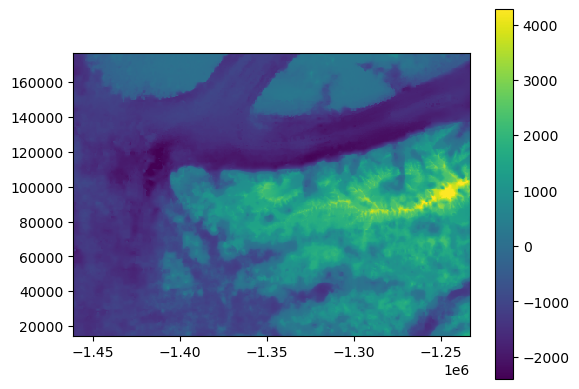

In [19]:
plt.pcolormesh(xx, yy, largeScaleChain.initial_bed)
plt.axis('scaled')
plt.colorbar()

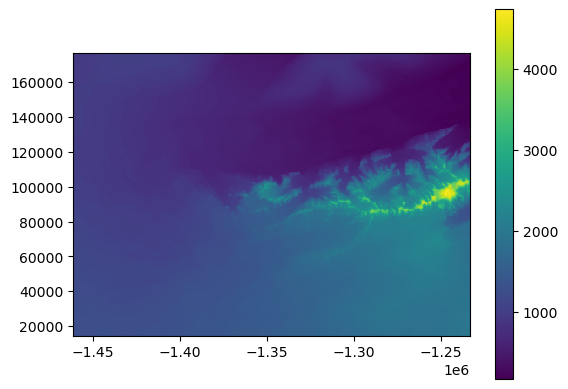

In [20]:
plt.pcolormesh(xx, yy, largeScaleChain.surf)
plt.axis('scaled')
plt.colorbar()

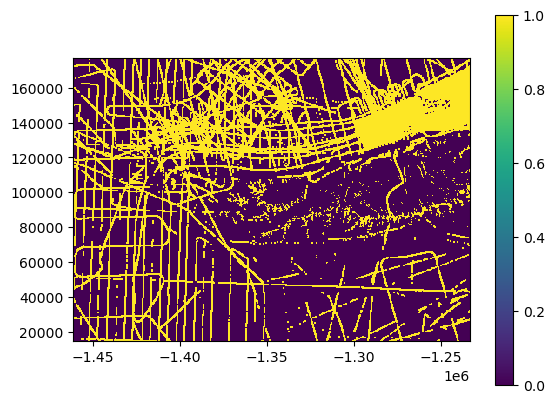

In [21]:
plt.pcolormesh(xx, yy, largeScaleChain.data_mask)
plt.axis('scaled')
plt.colorbar()

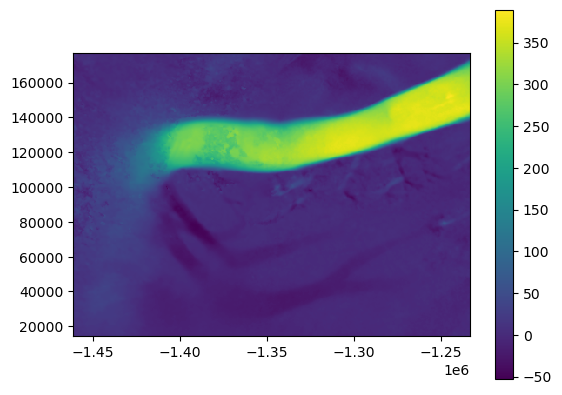

In [22]:
plt.pcolormesh(xx, yy, largeScaleChain.velx)
plt.axis('scaled')
plt.colorbar()

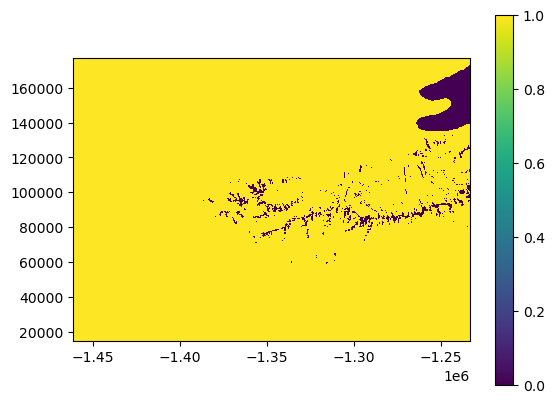

In [23]:
plt.pcolormesh(xx, yy, largeScaleChain.grounded_ice_mask)
plt.axis('scaled')
plt.colorbar()

The second function required, is *set_update_region*. In this function, the first boolean argument decide whether the MCMC update will be inside the high velocity, the second argument specify the exact region of high velocity (where the high_vel_mask == 1)

In [24]:
largeScaleChain.set_update_region(True,highvel_mask)

the update blocks is set to be randomly generated for any locations inside the given region


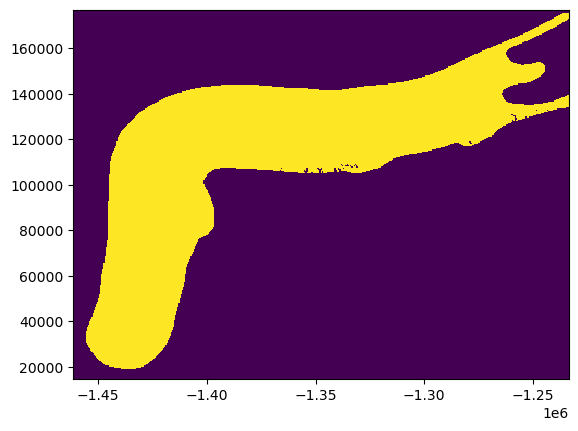

In [25]:
plt.pcolormesh(xx,yy,highvel_mask)

We also want to specify how we want to define the loss function used in the chain.

*map_func* determine the distribution of mass conservation residuals, whereas the *diff_func* determine the distribution of the difference between radar measurements and simulated topography. If the residuals has a Gaussian distribution, the corresponding function will be 'sumsquare'. If you do not want to include either of these loss, simple put *map_func = None* or *diff_func = None*. 

*sigma_mc* and *sigma_data* determine the standard deviation of the distribution of mass conservation residual or differences to radar data. *massConvInRegion* and *dataDiffInRegion* specify whether the two losses should be calculated for only inside the high velocity region or not

In [26]:
mc_res_bm = Topography.get_mass_conservation_residual(bedmachine_bed,bedmap_surf,velx,vely,dhdt,smb,resolution)

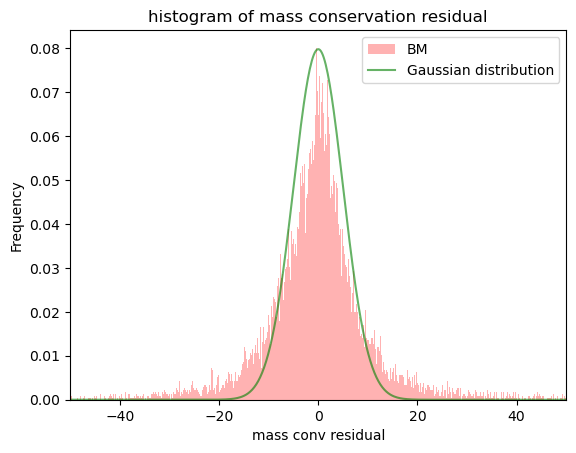

In [27]:
sigma3 = 5
xl3=np.linspace(-100, 100, num=1000)
gaussian_model=1/(sigma3*np.sqrt(2*np.pi))*np.exp(-0.5*np.square(xl3/sigma3))

# here, we filter mc_res_bm to only account for mass flux residuals inside the high velocity region
mc_res_bm_sr2 = mc_res_bm[highvel_mask==1]
mc_res_bm_sr2_f = mc_res_bm_sr2.flatten()
mc_res_bm_sr2_f = mc_res_bm_sr2_f[~np.isnan(mc_res_bm_sr2_f)]

plt.hist(mc_res_bm_sr2_f, bins=5000, facecolor='red', alpha=0.3,density=True,label='BM')
plt.plot(xl3, gaussian_model, color='Green',alpha=0.6, label='Gaussian distribution')
plt.xlim([-50,50]);

plt.legend()
plt.xlabel('mass conv residual');
plt.ylabel('Frequency');
plt.title('histogram of mass conservation residual')
plt.show()

Setting up the loss function for the large-scale chain. Here, we only use mass conservation residuals as the loss and ignore the different to bed elevation measurements, because the chains will always perserve the radar measurements.

Use 'sumsquare' will set the loss function as sum of squared mass conservation residuals inside the high-velocity region, which represent the pdf of a Gaussian distribution with standard deviation 'sigma_mc'

In [28]:
largeScaleChain.set_loss_type(map_func='sumsquare', sigma_mc=5, massConvInRegion=True)

To directly calculate the loss of BedMachine topography in terms of mass conservation residuals, we can directly calls:

largeScaleChain.loss(mass_conservation_residuals, difference_to_radar_measurements)

the _loss()_ function returns three values: the total loss, mass conservation loss (loss based on mass conservation residuals) and measurements data loss (loss based on differences between the topography and the radar measurements). The total loss equals mass conservation loss plus radar measurements loss.

Because we only set-up the mass conservation loss, the difference_to_radar_measurements can be left out

In [29]:
largeScaleChain.loss(mc_res_bm, 0)

(127614.46862566605, 127614.46862566605, 0.0)

For more information regarding these two functions, please check the documentation for MCMC.py

An example of setting up both mass conservation loss and measurements data loss

largeScaleChain.set_loss_type(map_func='sumsquare', sigma_mc=5, massConvInRegion=True,
                             diff_func='sumsquare', sigma_data=10, dataDiffInRegion=True)

Then the loss function will return different things

largeScaleChain.loss(mc_res_bm, bedmachine_bed - cond_bed)

will returns, for example

(2206762.607690888, 139380.26325314105, 2067382.3444377468)

Here, the three values represents the total loss, the mass conservation loss, and the radar measurements loss.

#### Initiate an object of the class RandField

Next step is to set up the parameters of the random field perturbation

In [30]:
range_max_x = 50e3 
range_max_y = 50e3
range_min_x = 10e3
range_min_y = 10e3
scale_min = 50 
scale_max = 150
nugget_max = 0
random_field_model = 'Matern'
isotropic = True
smoothness = V1_p[2]

rf1 = MCMC.RandField(range_min_x, range_max_x, range_min_y, range_max_y, scale_min, scale_max, nugget_max, random_field_model, isotropic, smoothness = smoothness)

Before using the `RandField` object in an MCMC chain or for field generation, call method `set_block_sizes` and method`set_weight_param` to initialize block size ranges and conditional weighting parameters.


Then we can set up the size of the blocks used in the update

*set_block_sizes* function create a list of possible block sizes, which will be accessible via rf1.pairs after the function is called.

*set_block_sizes* function also has an optional argument *steps*, it specify how many 'steps' between the min_block and max_block will be divided into. For example, for min_block_x = 20 and max_block_x = 50, steps = 4 will divide the range into [20, 30, 40, 50]. For min_block_y = 10 and max_block_y = 55, it will divide the range into [10, 25, 40, 55]. Then each size on the list for x will pair up with all size on the list for y, creating a list of following

rf1.pairs = [[20,10],[20,25],[20,40],[20,55],[30,10],[30,25],[30,40],[30,55],[40,10],[40,25],[40,40],[40,55],[50,10],[50,25],[50,40],[50,55]]

When randomly deciding the size of the block, one of the size on the list will be chosen and will be used

In [31]:
min_block_x = 50
max_block_x = 80
min_block_y = 50
max_block_y = 80
rf1.set_block_sizes(min_block_x, max_block_x, min_block_y, max_block_y)

Finally, if you wish to use conditional block update, then the RandField object requires specifying the logistic function used to calculate the conditioning weight of the random field

The logistic function is used to calculate the weight for conditioning to the edge of the block and the weight for conditioning to radar measurements. When updating the field, the weight will be 1 at conditioning data and block edges, and it logistically decays to 0 at location *max_dist* away from any conditioning data

In [32]:
logis_func_L = 2
logis_func_x0 = 0
logis_func_k = 6
logis_func_offset = 1
max_dist = V1_p[0] # set to the distance between two points on the map where the correlation vanish / is minimal

rf1.set_weight_param(logis_func_L, logis_func_x0, logis_func_k, logis_func_offset, max_dist, resolution)

#### Run the Markov chain

At last, these information need to be known to the crf chain. The function *set_crf_data_weight* calculate the weight for conditioning to the radar measurements

In [33]:
largeScaleChain.set_crf_data_weight(rf1)
largeScaleChain.set_update_type('CRF_weight')

The update block is set to conditional random field generated by calculating weights with logistic function


In [34]:
np.savetxt('data_weight_rutford.txt', largeScaleChain.crf_data_weight)

In [35]:
largeScaleChain.crf_data_weight = np.loadtxt('data_weight_rutford.txt')
largeScaleChain.set_update_type('CRF_weight')

The update block is set to conditional random field generated by calculating weights with logistic function


And then we can start the chain by specifying how many iterations it should go through

In [36]:
seed = 20251019
rng = np.random.default_rng(seed)

beds, loss_mc, loss_data, loss, steps, resampled_times, blocks_used  = largeScaleChain.run(n_iter=4000, RF=rf1, rng_seed=rng, only_save_last_bed=False, info_per_iter = 100)


i: 100 mc loss: 2.246e+05 data loss: 0.000e+00 loss: 2.246e+05 acceptance rate: 0.6633663366336634
i: 200 mc loss: 2.244e+05 data loss: 0.000e+00 loss: 2.244e+05 acceptance rate: 0.6119402985074627
i: 300 mc loss: 2.242e+05 data loss: 0.000e+00 loss: 2.242e+05 acceptance rate: 0.6179401993355482
i: 400 mc loss: 2.238e+05 data loss: 0.000e+00 loss: 2.238e+05 acceptance rate: 0.5935162094763092
i: 500 mc loss: 2.236e+05 data loss: 0.000e+00 loss: 2.236e+05 acceptance rate: 0.5888223552894212
i: 600 mc loss: 2.234e+05 data loss: 0.000e+00 loss: 2.234e+05 acceptance rate: 0.5840266222961731
i: 700 mc loss: 2.232e+05 data loss: 0.000e+00 loss: 2.232e+05 acceptance rate: 0.5863052781740371
i: 800 mc loss: 2.229e+05 data loss: 0.000e+00 loss: 2.229e+05 acceptance rate: 0.5905118601747815
i: 900 mc loss: 2.227e+05 data loss: 0.000e+00 loss: 2.227e+05 acceptance rate: 0.5926748057713651
i: 1000 mc loss: 2.225e+05 data loss: 0.000e+00 loss: 2.225e+05 acceptance rate: 0.5894105894105894
i: 1100 m

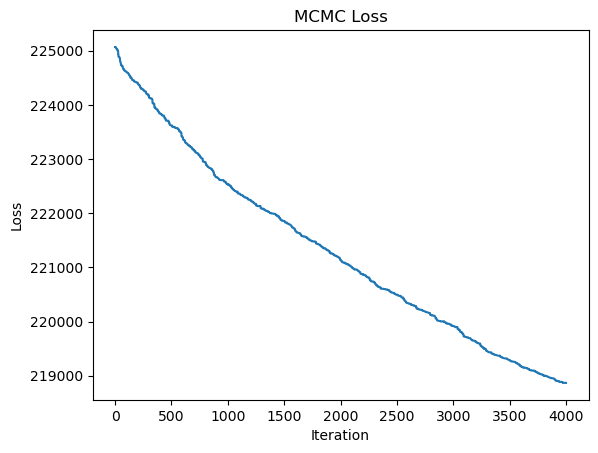

In [37]:
plt.plot(loss)
plt.xlabel('Iteration');
plt.ylabel('Loss');
plt.title('MCMC Loss')
plt.show()


In [47]:
import numpy as np
beds = np.loadtxt('sgs_bed_rutford_cropped2.txt')
largeScaleChain.initial_bed = beds

In [48]:
n_iter = 4000
for i in range(0,11):
    print(str(i*n_iter))

0
4000
8000
12000
16000
20000
24000
28000
32000
36000
40000


In [50]:
seed = 20251019
rng = np.random.default_rng(seed)
n_iter = 10000

for i in range(10):
    beds, loss_mc, loss_data, loss, steps, resampled_times, blocks_used  = largeScaleChain.run(n_iter=n_iter, RF=rf1, only_save_last_bed=True, info_per_iter = 500)
    # save all the data in every run of the algorithm
    np.savetxt('Rutford_loss_'+str(i*n_iter)+'.txt', loss)
    np.savetxt('Rutford_steps_'+str(i*n_iter)+'.txt', steps) 
    np.savetxt('Rutford_bed_'+str(i*n_iter)+'.txt', beds[-1])
    # set up the next chain
    largeScaleChain.initial_bed = beds

i: 500 mc loss: 2.241e+05 data loss: 0.000e+00 loss: 2.241e+05 acceptance rate: 0.46506986027944114
i: 1000 mc loss: 2.229e+05 data loss: 0.000e+00 loss: 2.229e+05 acceptance rate: 0.4675324675324675
i: 1500 mc loss: 2.221e+05 data loss: 0.000e+00 loss: 2.221e+05 acceptance rate: 0.48634243837441704
i: 2000 mc loss: 2.215e+05 data loss: 0.000e+00 loss: 2.215e+05 acceptance rate: 0.487256371814093
i: 2500 mc loss: 2.210e+05 data loss: 0.000e+00 loss: 2.210e+05 acceptance rate: 0.49140343862455016
i: 3000 mc loss: 2.205e+05 data loss: 0.000e+00 loss: 2.205e+05 acceptance rate: 0.4948350549816728
i: 3500 mc loss: 2.199e+05 data loss: 0.000e+00 loss: 2.199e+05 acceptance rate: 0.4975721222507855
i: 4000 mc loss: 2.195e+05 data loss: 0.000e+00 loss: 2.195e+05 acceptance rate: 0.4958760309922519
i: 4500 mc loss: 2.191e+05 data loss: 0.000e+00 loss: 2.191e+05 acceptance rate: 0.4990002221728505
i: 5000 mc loss: 2.188e+05 data loss: 0.000e+00 loss: 2.188e+05 acceptance rate: 0.498500299940012


MemoryError: Unable to allocate 11.0 GiB for an array with shape (10000, 325, 456) and data type float64

^^^ The error occurred because the MCMC code attempted to store all 10,000 bed realizations as a single 3D array of size. This requires about 11 GB of RAM which exceeds the available memory.

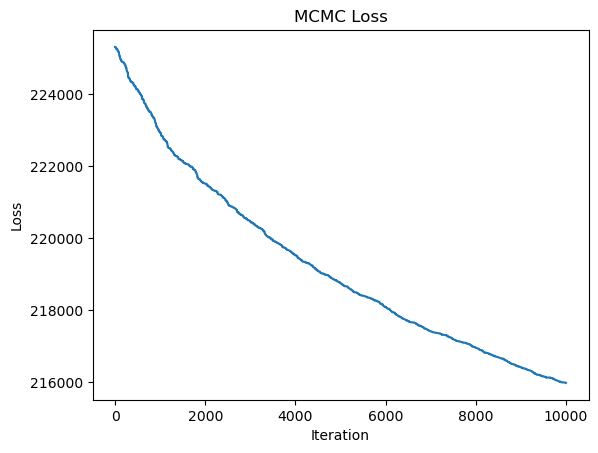

In [59]:
plt.plot(loss)
plt.xlabel('Iteration');
plt.ylabel('Loss');
plt.title('MCMC Loss')
plt.show()


### Verify Results

We can check several aspects of the results:

- How the topography deviate from radar measurements

- Mass flux residuals of the current topography

- How loss reduce over time

- Variogram of the simulated topography

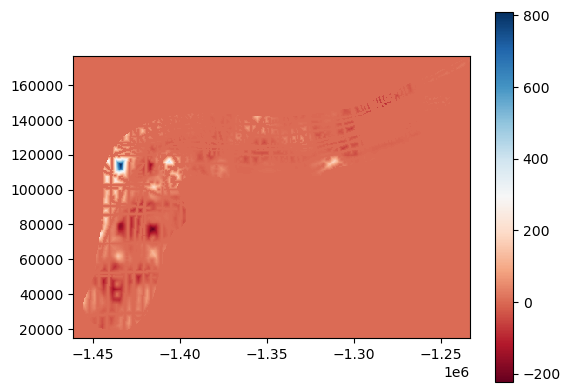

In [51]:
plt.pcolormesh(xx,yy,beds[-1]-beds[0],cmap='RdBu')
plt.axis('scaled')
plt.colorbar()

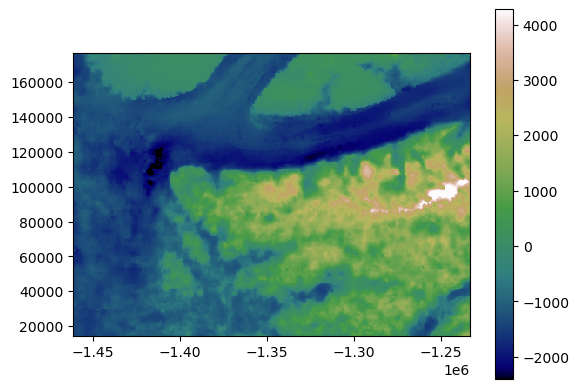

In [52]:
plt.pcolormesh(xx,yy,beds[0],cmap='gist_earth')
plt.axis('scaled')
plt.colorbar()

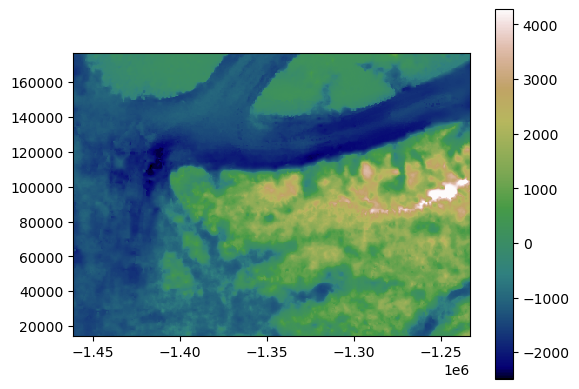

In [53]:
plt.pcolormesh(xx,yy,beds[-1],cmap='gist_earth')
plt.axis('scaled')
plt.colorbar()

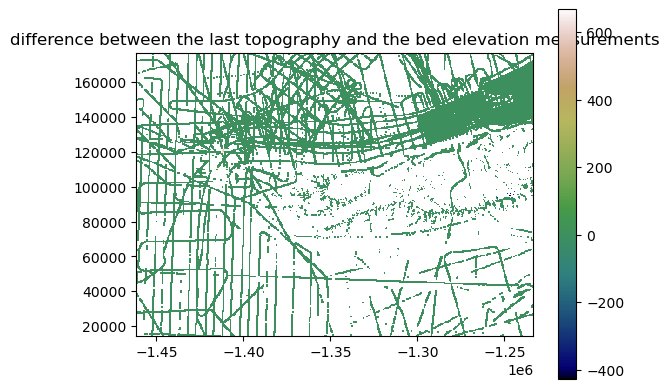

In [54]:
plt.pcolormesh(xx,yy,beds[-1] - cond_bed,cmap='gist_earth')
plt.title('difference between the last topography and the bed elevation measurements')
plt.axis('scaled')
plt.colorbar()

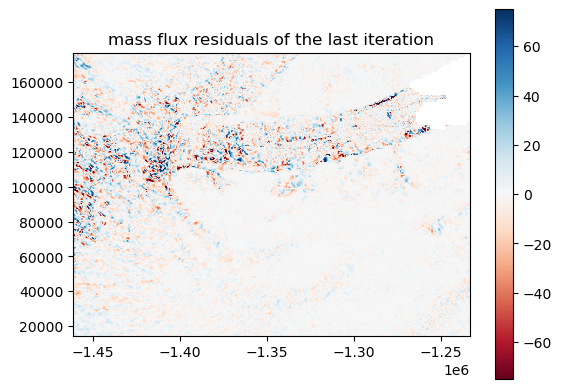

In [55]:
mass_flux_res = Topography.get_mass_conservation_residual(beds[-1],bedmap_surf,velx,vely,dhdt,smb,resolution)

plt.pcolormesh(xx,yy,mass_flux_res,cmap='RdBu',vmax=75,vmin=-75)
plt.title('mass flux residuals of the last iteration')
plt.axis('scaled')
plt.colorbar()

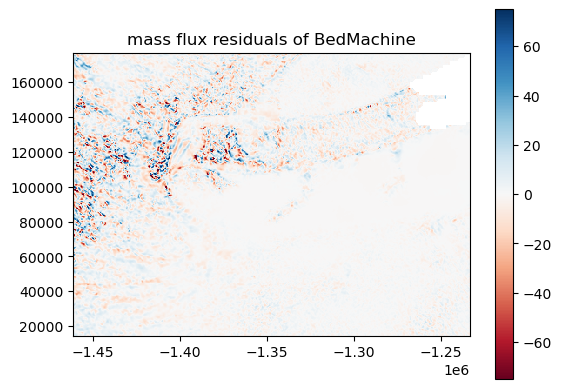

In [56]:
mc_res_bm = Topography.get_mass_conservation_residual(bedmachine_bed,bedmap_surf,velx,vely,dhdt,smb,resolution)

plt.pcolormesh(xx,yy,mc_res_bm,cmap='RdBu',vmax=75,vmin=-75)
plt.title('mass flux residuals of BedMachine')
plt.axis('scaled')
plt.colorbar()

In [57]:
loss_bedmachine = largeScaleChain.loss(mc_res_bm, bedmachine_bed - cond_bed)
loss_bedmachine

(127614.46862566605, 127614.46862566605, 0.0)

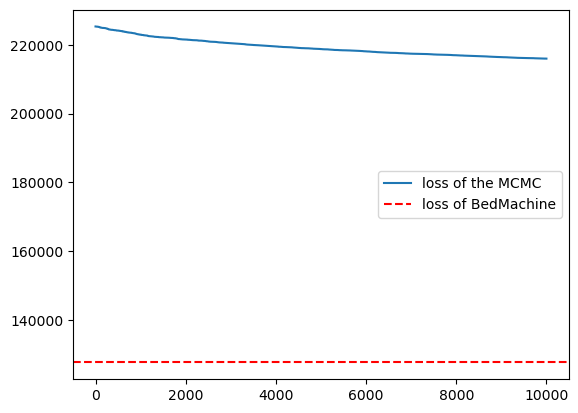

In [60]:
plt.plot(loss_mc,label='loss of the MCMC')
plt.axhline(loss_bedmachine[0],ls='--',c='red',label='loss of BedMachine')
plt.legend()

In [61]:
df['simulated_topography'] = sgs_bed.flatten()

In [62]:
# randomly drop out 50% of coordinates. Decrease this value if you have a lot of data and it takes a long time to run
df_sampled = df.sample(frac=0.4, random_state=42)
df_sampled = df_sampled[df_sampled["simulated_topography"].isnull() == False]
df_sampled = df_sampled[df_sampled["bedmap_mask"]==1]

# compute experimental (isotropic) variogram
coords = df_sampled[['x','y']].values
#values = df_sampled['simulated_topography']
values = df_sampled['simulated_topography']

maxlag = 80000      # maximum range distance
n_lags = 30         # num of bins (try decreasing if this is taking too long)

# compute variogram
V1 = skg.Variogram(coords, values, bin_func='even', 
                   n_lags=n_lags, maxlag=maxlag, normalize=False, 
                   model='matern', samples = 0.4)

# extract variogram values
xdata_sim = V1.bins
ydata_sim = V1.experimental
V1_p = V1.parameters

In [63]:
# randomly drop out 50% of coordinates. Decrease this value if you have a lot of data and it takes a long time to run
df_sampled = df.sample(frac=0.4, random_state=42)
df_sampled = df_sampled[df_sampled["cond_bed"].isnull() == False]
df_sampled = df_sampled[df_sampled["bedmap_mask"]==1]

# compute experimental (isotropic) variogram
coords = df_sampled[['x','y']].values
values = df_sampled['cond_bed']

maxlag = 80000      # maximum range distance
n_lags = 30         # num of bins (try decreasing if this is taking too long)

# compute variogram
V2 = skg.Variogram(coords, values, bin_func='even', 
                   n_lags=n_lags, maxlag=maxlag, normalize=False, 
                   model='matern', samples = 0.4)

# extract variogram values
xdata_cond = V2.bins
ydata_cond = V2.experimental
V2_p = V2.parameters

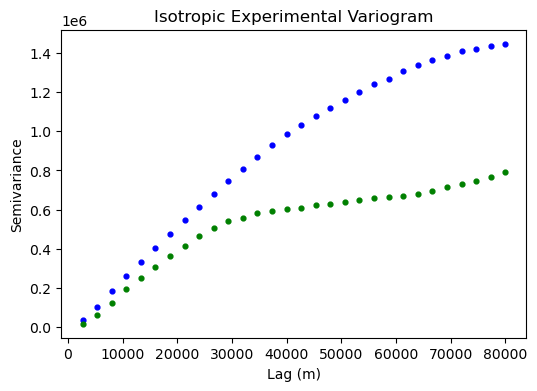

In [64]:
# compare experimental variogram
plt.figure(figsize=(6,4))
plt.scatter(xdata_sim, ydata_sim, s=12, c='b', label='variogram for simulated topography')
plt.scatter(xdata_cond, ydata_cond, s=12, c='g', label='variogram for radar measurements')
plt.title('Isotropic Experimental Variogram')
plt.xlabel('Lag (m)'); plt.ylabel('Semivariance')
plt.show()

### Save Results

Please remember to save the result for comparison later. For example, I always save the loss of every iteration, the acceptance rate (steps), and some topography.

For example, you can save the topography every 1000 iteration:

In [65]:
beds.shape

(10000, 325, 456)

Or you can save beds at more iterations. For the example, the code below save beds for every 100 iteration, while we are running the chain for 1000 iterations

In [49]:
largeScaleChain.initial_bed = beds[-1]

beds2, loss_mc2, loss_data2, loss2, steps2, resampled_times2, blocks_used2 = largeScaleChain.run(n_iter=4000, RF=rf1, rng_seed=rng, only_save_last_bed=False, info_per_iter = 100)

i: 100 mc loss: 2.186e+05 data loss: 0.000e+00 loss: 2.186e+05 acceptance rate: 0.594059405940594
i: 200 mc loss: 2.186e+05 data loss: 0.000e+00 loss: 2.186e+05 acceptance rate: 0.527363184079602
i: 300 mc loss: 2.185e+05 data loss: 0.000e+00 loss: 2.185e+05 acceptance rate: 0.5614617940199336
i: 400 mc loss: 2.183e+05 data loss: 0.000e+00 loss: 2.183e+05 acceptance rate: 0.5685785536159601
i: 500 mc loss: 2.183e+05 data loss: 0.000e+00 loss: 2.183e+05 acceptance rate: 0.564870259481038
i: 600 mc loss: 2.182e+05 data loss: 0.000e+00 loss: 2.182e+05 acceptance rate: 0.562396006655574
i: 700 mc loss: 2.181e+05 data loss: 0.000e+00 loss: 2.181e+05 acceptance rate: 0.5706134094151213
i: 800 mc loss: 2.180e+05 data loss: 0.000e+00 loss: 2.180e+05 acceptance rate: 0.5692883895131086
i: 900 mc loss: 2.179e+05 data loss: 0.000e+00 loss: 2.179e+05 acceptance rate: 0.5782463928967814
i: 1000 mc loss: 2.178e+05 data loss: 0.000e+00 loss: 2.178e+05 acceptance rate: 0.5804195804195804
i: 1100 mc lo

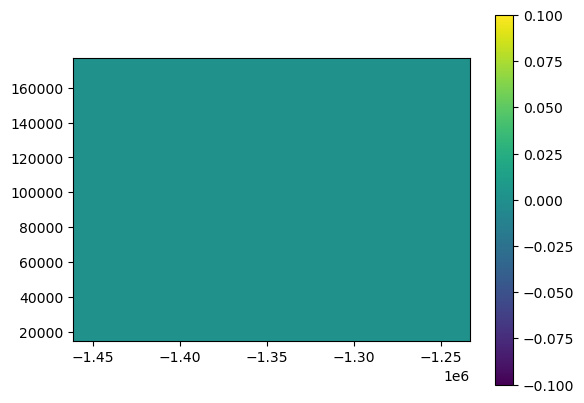

In [50]:
plt.pcolormesh(xx,yy,beds[-1] - beds2[0],cmap='viridis')
plt.axis('scaled')
plt.colorbar()

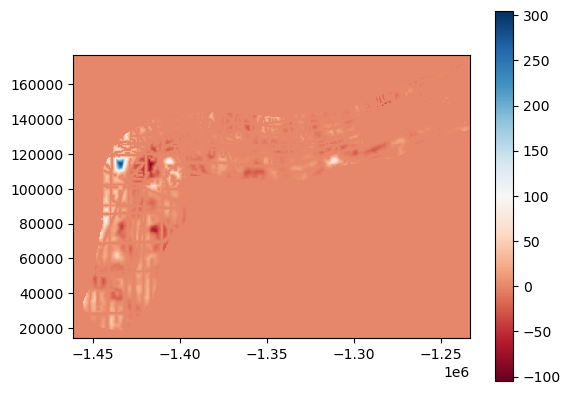

In [51]:
plt.pcolormesh(xx,yy,beds2[-1]-beds2[0],cmap='RdBu')
plt.axis('scaled')
plt.colorbar()

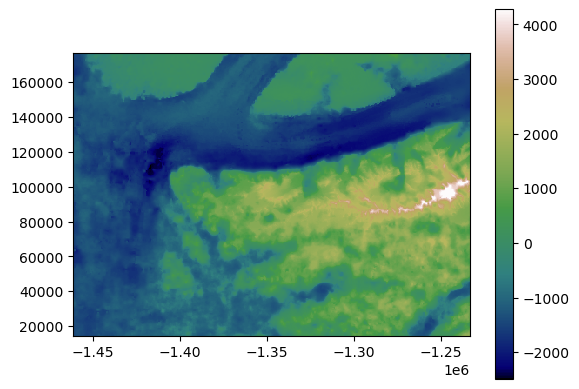

In [52]:
plt.pcolormesh(xx,yy,beds2[-1],cmap='gist_earth')
plt.axis('scaled')
plt.colorbar()